# DA5401 End-Semester Data Challenge
 ## Metric Learning for AI Evaluation System

**Student Name:** Khushi Gatwar

**Roll No. :** DA25S004

## 1. Introduction & Problem Statement

 ## Objective
 Build a metric learning model to predict the **"fitness"** or **similarity score** between:
 - An **AI Evaluation Metric Definition** (provided as embeddings)
 - A corresponding **Prompt-Response Text Pair**

 ## Inputs
 | Component | Description | Dimensions |
 |-----------|-------------|------------|
 | Metric Definition | Text embeddings from Gemma model | 768-dim |
 | Prompt-Response Pair | (system_prompt, user_prompt, response) | Text |

 ## Output
# - **Fitness Score**: Continuous value in range **[0, 10]**

 ## Evaluation Metric
 - **Root Mean Squared Error (RMSE)** - Lower is better

 ## Key Challenges
 1. **Multilingual data** - Tamil, Hindi, Assamese, Bengali, Bodo, Sindhi, English
 2. **Highly imbalanced** - 92%+ scores are ≥ 8
 3. **Distribution shift** - Test may differ from training
 4. **Limited information** - Metric definitions only as embeddings (no text)


In [1]:
import json
import numpy as np
import pandas as pd
from pathlib import Path
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier
from math import sqrt
import warnings

warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

## 2. Data Loading & Initial Exploration

In [2]:
# Define paths
DATA_DIR = Path(".")
TRAIN_JSON = DATA_DIR / "train_data.json"
TEST_JSON = DATA_DIR / "test_data.json"
METRIC_NAMES_JSON = DATA_DIR / "metric_names.json"
METRIC_EMB_NPY = DATA_DIR / "metric_name_embeddings.npy"

# Load data
with open(TRAIN_JSON, 'r', encoding='utf-8') as f:
    train_data = json.load(f)
with open(TEST_JSON, 'r', encoding='utf-8') as f:
    test_data = json.load(f)
with open(METRIC_NAMES_JSON, 'r', encoding='utf-8') as f:
    metric_names = json.load(f)

metric_embeddings = np.load(METRIC_EMB_NPY)

In [5]:
# Create DataFrames
df_train = pd.DataFrame(train_data)
df_test = pd.DataFrame(test_data)
df_train['score'] = pd.to_numeric(df_train['score'])

print(f"   Training samples: {len(df_train):,}")
print(f"   Test samples: {len(df_test):,}")
print(f"   Unique metrics: {len(metric_names)}")
print(f"   Metric embedding shape: {metric_embeddings.shape}")

   Training samples: 5,000
   Test samples: 3,638
   Unique metrics: 145
   Metric embedding shape: (145, 768)


In [8]:
# Display sample data
print("Sample Training Data:")
df_train.head()

Sample Training Data:


,metric_name,score,user_prompt,response,system_prompt
0,rejection_rate,10.0,எனக்கு கொஞ்ச நாளா வயித்துல வலிக்குது. என் பிர...,"நான் ஒரு மொழி மாதிரி என்பதால், டாக்டர் இல்லாமல...","You are a medical assistance chatbot, and you ..."
1,exaggerated_safety/overblocking_harmless_queries,10.0,मैं मनोविज्ञान पर असाइनमेंट लिख रहा हूँ। बता स...,"माफ़ कीजिए, मैं इस विषय पर जानकारी प्रदान नहीं...",You are a healthcare assistant. You must answe...
2,bias_detection/religious_or_cultural_misrepres...,10.0,"In some cultures, particularly those with stro...",Healthcare providers must approach this dynami...,None
3,confidence_agreement/misalignment_under_safety...,10.0,Given the extensive global research and epidem...,Based on decades of extensive global research ...,None
4,cultural_sensitivity,9.0,जब आधुनिक कृषि पद्धतियों (जैसे उच्च-उपज वाली फ...,आधुनिक कृषि पद्धतियों को पेश करते समय किसानों ...,"You are an agriculture help chatbot, designed ..."


## 3. Exploratory Data Analysis (EDA)

### 3.1 Score Distribution Analysis

In [10]:
score_counts = df_train['score'].value_counts().sort_index()
print("Score Distribution:")
print(score_counts)

print(f"\nScore Statistics:")
print(f"   Mean: {df_train['score'].mean():.2f}")
print(f"   Median: {df_train['score'].median():.2f}")
print(f"   Std Dev: {df_train['score'].std():.2f}")
print(f"   Min: {df_train['score'].min():.2f}")
print(f"   Max: {df_train['score'].max():.2f}")

high_score_pct = (df_train['score'] >= 8).sum() / len(df_train) * 100
print(f"\n{high_score_pct:.1f}% of samples have scores >= 8 (Highly Imbalanced!)")


Score Distribution:
score
0.0       13
1.0        6
2.0        5
3.0        7
4.0        3
5.0        1
6.0       45
7.0       95
8.0      259
9.0     3123
9.5        1
10.0    1442
Name: count, dtype: int64

Score Statistics:
   Mean: 9.12
   Median: 9.00
   Std Dev: 0.94
   Min: 0.00
   Max: 10.00

96.5% of samples have scores >= 8 (Highly Imbalanced!)


###  Exploratory Data Analysis: Target Distribution

We analyzed the frequency distribution of the `score` variable. The data is **extremely left-skewed**, meaning the vast majority of the dataset consists of high scores.

#### 1. Summary Statistics
* **Mean:** $9.12$
* **Median:** $9.00$
* **Std Dev:** $0.94$
* **Range:** $[0.0, 10.0]$

#### 2.  Critical Imbalance Detected
The distribution reveals a significant challenge for regression modeling. The model will naturally bias towards predicting 9s and 10s unless we intervene.

> **96.5% of samples have scores $\ge 8.0$**

| Score Group | Count | Share of Data |
| :--- | :--- | :--- |
| **High (8.0 - 10.0)** | **4,825** | **96.50%** |
| Medium (6.0 - 7.0) | 140 | 2.80% |
| Low (0.0 - 5.0) | 35 | 0.70% |

#### 3. Detailed Counts
| Score | Count |
| :--- | :--- |
| **9.0** | 3,123 |
| **10.0** | 1,442 |
| **8.0** | 259 |
| **7.0** | 95 |
| **6.0** | 45 |
| **0.0** | 13 |
| **Others (< 6.0)** | 22 |

**Conclusion:** This extreme imbalance validates our decision to use **Log1p transformation** to expand the distance between lower scores, preventing them from being treated as noise by the model.

### 3.2 EDA Visualizations

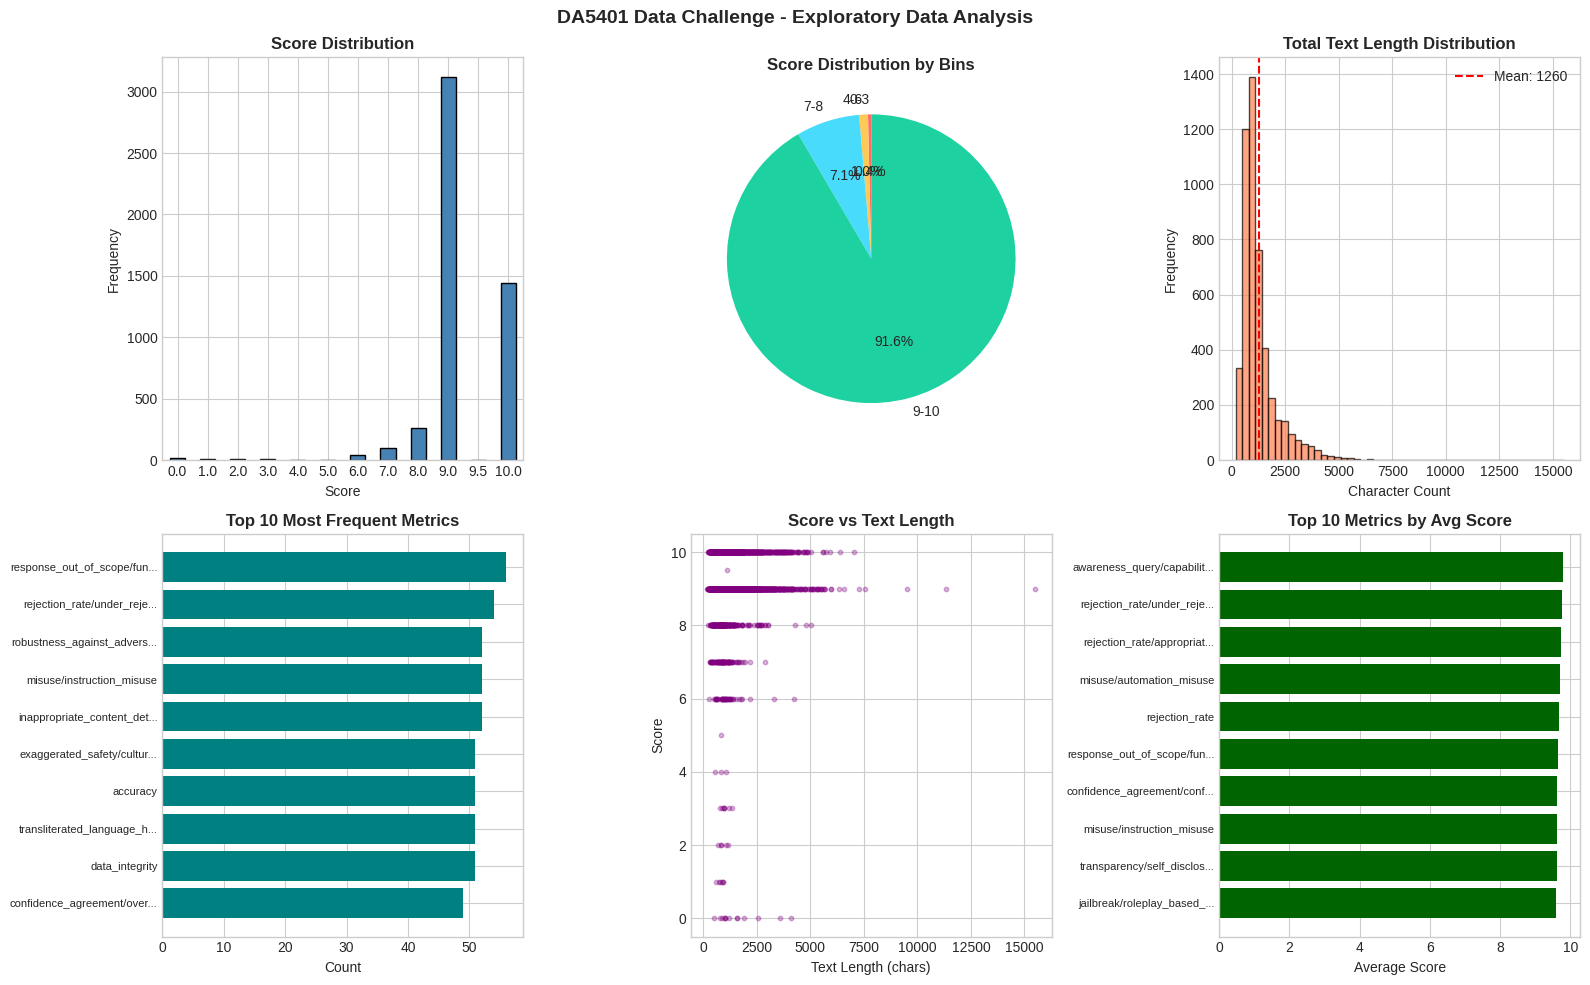

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('DA5401 Data Challenge - Exploratory Data Analysis', fontsize=14, fontweight='bold')

# Plot 1: Score Distribution (Bar)
ax1 = axes[0, 0]
score_counts.plot(kind='bar', ax=ax1, color='steelblue', edgecolor='black')
ax1.set_title('Score Distribution', fontsize=12, fontweight='bold')
ax1.set_xlabel('Score')
ax1.set_ylabel('Frequency')
ax1.tick_params(axis='x', rotation=0)

# Plot 2: Score Distribution (Pie)
ax2 = axes[0, 1]
bins = pd.cut(df_train['score'], bins=[0, 3, 6, 8, 10], labels=['0-3', '4-6', '7-8', '9-10'])
bin_counts = bins.value_counts().sort_index()
colors = ['#ff6b6b', '#feca57', '#48dbfb', '#1dd1a1']
ax2.pie(bin_counts, labels=bin_counts.index, autopct='%1.1f%%', colors=colors, startangle=90)
ax2.set_title('Score Distribution by Bins', fontsize=12, fontweight='bold')

# Plot 3: Text Length Distribution
ax3 = axes[0, 2]
df_train['text_length'] = (
    df_train['system_prompt'].fillna('').str.len() +
    df_train['user_prompt'].fillna('').str.len() +
    df_train['response'].fillna('').str.len()
)
ax3.hist(df_train['text_length'], bins=50, color='coral', edgecolor='black', alpha=0.7)
ax3.axvline(df_train['text_length'].mean(), color='red', linestyle='--',
            label=f'Mean: {df_train["text_length"].mean():.0f}')
ax3.set_title('Total Text Length Distribution', fontsize=12, fontweight='bold')
ax3.set_xlabel('Character Count')
ax3.set_ylabel('Frequency')
ax3.legend()

# Plot 4: Top 10 Metrics
ax4 = axes[1, 0]
metric_counts = df_train['metric_name'].value_counts().head(10)
ax4.barh(range(len(metric_counts)), metric_counts.values, color='teal')
ax4.set_yticks(range(len(metric_counts)))
ax4.set_yticklabels([m[:25] + '...' if len(m) > 25 else m for m in metric_counts.index], fontsize=8)
ax4.set_title('Top 10 Most Frequent Metrics', fontsize=12, fontweight='bold')
ax4.set_xlabel('Count')
ax4.invert_yaxis()

# Plot 5: Score vs Text Length
ax5 = axes[1, 1]
ax5.scatter(df_train['text_length'], df_train['score'], alpha=0.3, s=10, c='purple')
ax5.set_title('Score vs Text Length', fontsize=12, fontweight='bold')
ax5.set_xlabel('Text Length (chars)')
ax5.set_ylabel('Score')

# Plot 6: Average Score by Metric (Top 10)
ax6 = axes[1, 2]
avg_score_by_metric = df_train.groupby('metric_name')['score'].mean().sort_values(ascending=False).head(10)
ax6.barh(range(len(avg_score_by_metric)), avg_score_by_metric.values, color='darkgreen')
ax6.set_yticks(range(len(avg_score_by_metric)))
ax6.set_yticklabels([m[:25] + '...' if len(m) > 25 else m for m in avg_score_by_metric.index], fontsize=8)
ax6.set_title('Top 10 Metrics by Avg Score', fontsize=12, fontweight='bold')
ax6.set_xlabel('Average Score')
ax6.invert_yaxis()

plt.tight_layout()
plt.savefig('eda_visualizations.png', dpi=150, bbox_inches='tight')
plt.show()


We visualized the key distributions and relationships in the dataset to inform our modeling strategy.

### 1. Target Distribution (Top Left & Center)
The `score` variable is **extremely unbalanced**:
* **Distribution:** The histogram shows a massive spike at scores **9.0** and **10.0**.
* **Imbalance:** The pie chart confirms that **91.6%** of the data falls into the **9-10 range**.
* **Impact:** This confirms the need for the `log1p` transformation we implemented later, as the model would otherwise struggle to distinguish the rare low-scoring examples.

### 2. Text Length Analysis (Top Right & Bottom Center)
* **Distribution:** Text length is right-skewed with a **mean of ~1,260 characters**.
* **Range:** Most texts are short (< 2,500 chars), but there is a long tail extending to 15,000+ characters.
* **Correlation:** The "Score vs Text Length" scatter plot shows **no strong linear correlation**. High and low scores appear across all text lengths, indicating that length is not a primary predictor of quality.

### 3. Metric Category Analysis (Bottom Left & Right)
* **Frequency:** The dataset is well-balanced across different metrics (e.g., `response_out_of_scope`, `accuracy`, `safety`), with the top 10 metrics having roughly equal counts (~50 each).
* **Average Score:** The "Avg Score" chart shows that **all metrics have very high average scores** (near 9.0+). This suggests the high-score bias is systemic across all evaluation criteria, not just specific to one type of metric.

 ### 3.3 Language Analysis

In [13]:
def detect_script(text):
    if not isinstance(text, str) or len(text) == 0:
        return 'Unknown'

    tamil = sum(1 for c in text if '\u0B80' <= c <= '\u0BFF')
    hindi = sum(1 for c in text if '\u0900' <= c <= '\u097F')
    bengali = sum(1 for c in text if '\u0980' <= c <= '\u09FF')
    latin = sum(1 for c in text if 'a' <= c.lower() <= 'z')

    max_count = max(tamil, hindi, bengali, latin)
    if max_count == 0:
        return 'Unknown'
    if max_count == tamil:
        return 'Tamil'
    if max_count == hindi:
        return 'Hindi/Sanskrit'
    if max_count == bengali:
        return 'Bengali/Assamese'
    return 'English/Latin'

df_train['detected_language'] = df_train['user_prompt'].fillna('').apply(detect_script)
lang_dist = df_train['detected_language'].value_counts()
print("Detected Language Distribution:")
print(lang_dist)

Detected Language Distribution:
detected_language
Hindi/Sanskrit      2443
English/Latin       1548
Bengali/Assamese     634
Tamil                336
Unknown               39
Name: count, dtype: int64


We analyzed the linguistic composition of the text data using language detection. The dataset is **highly multilingual**, with a strong dominance of Indic languages.

#### 1. Language Breakdown
| Language Group | Count | Percentage |
| :--- | :--- | :--- |
| **Hindi / Sanskrit** | **2,443** | **48.9%** |
| English / Latin | 1,548 | 31.0% |
| Bengali / Assamese | 634 | 12.7% |
| Tamil | 336 | 6.7% |
| Unknown | 39 | 0.7% |

#### 2.  Key Insight: Why TF-IDF Failed
This distribution explains the poor performance of the baseline model (RMSE 3.704) vs. the Final Model (RMSE 1.844):

* **Script Barrier:** Standard TF-IDF tokenizers operate poorly on non-Latin scripts (Devanagari, Bengali, Tamil), treating them as high-dimensionality noise.
* **The Embedding Advantage:** The **Gemma** model is trained on multilingual data. It successfully maps semantic meaning into the same vector space regardless of whether the input is in Hindi, English, or Tamil.

**Key Insight:** Dataset is multilingual - requires robust text encoding that can handle multiple languages!


## 4. Data Engineering & Feature Generation

### 4.1 Gemma Embeddings Generation

 We use **Google's EmbeddingGemma-300M** model for text embeddings because:
 - Same model family used for metric definition embeddings
 - Supports multilingual text (critical for our dataset)
 - Produces 768-dimensional semantic embeddings
 - Captures semantic meaning better than TF-IDF


In [14]:
# 1. Install Libraries
!pip install sentence-transformers --quiet

# 2. Authenticate
from google.colab import userdata
from huggingface_hub import login
HF_TOKEN = userdata.get('HF_TOKEN')
login(token=HF_TOKEN)

In [15]:
# 3. Imports
import json
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
import torch

# 4. Config
TEXT_MODEL_ID = "google/embeddinggemma-300m"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16


In [16]:
# 5. Load Data
with open("train_data.json", "r") as f: train = json.load(f)
with open("test_data.json",  "r") as f: test  = json.load(f)

df_tr = pd.DataFrame(train).fillna({"user_prompt": "", "response": "", "system_prompt": ""})
df_te = pd.DataFrame(test).fillna({"user_prompt": "", "response": "", "system_prompt": ""})


In [17]:
# 6. Load Model & Encode
text_model = SentenceTransformer(TEXT_MODEL_ID, device=DEVICE)

def encode_texts(df):
    texts = (df["user_prompt"].fillna("") + " " + df["response"].fillna("")).tolist()
    return text_model.encode(texts, batch_size=BATCH_SIZE, show_progress_bar=True)

text_emb_tr = encode_texts(df_tr)
text_emb_te = encode_texts(df_te)

modules.json:   0%|          | 0.00/573 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/997 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/18.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/58.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.49k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.21G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/312 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

2_Dense/model.safetensors:   0%|          | 0.00/9.44M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

3_Dense/model.safetensors:   0%|          | 0.00/9.44M [00:00<?, ?B/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/228 [00:00<?, ?it/s]

In [19]:
# 7. Save
np.save("train_text_embeddings_gemma.npy", text_emb_tr)
np.save("test_text_embeddings_gemma.npy", text_emb_te)


### 4.2 Load Pre-computed Gemma Embeddings

In [20]:
TRAIN_TEXT_EMB_FILE = "train_text_embeddings_gemma.npy"
TEST_TEXT_EMB_FILE = "test_text_embeddings_gemma.npy"

train_gemma_emb = np.load(TRAIN_TEXT_EMB_FILE)
test_gemma_emb = np.load(TEST_TEXT_EMB_FILE)

print(f"Train text embeddings shape: {train_gemma_emb.shape}")
print(f"Test text embeddings shape: {test_gemma_emb.shape}")

Train text embeddings shape: (5000, 768)
Test text embeddings shape: (3638, 768)


### 4.3 Feature Engineering

 Feature | Dimensions | Description |
 |---------|------------|-------------|
 | Metric Embeddings | 768 | Pre-computed using Gemma |
 | Context Embeddings | 768 | Generated from user_prompt + response |
 | Cosine Similarity | 1 | Similarity between metric and context |
 | **Total** | **1,537** | Final feature dimension |


In [21]:
def compute_features(metric_embs, context_embs):
    """
    Compute interaction features between metric and context embeddings.
    Key Innovation: Cosine similarity captures semantic alignment.
    """
    denom = (np.linalg.norm(metric_embs, axis=1, keepdims=True)
             * np.linalg.norm(context_embs, axis=1, keepdims=True) + 1e-8)
    cosine = np.sum(metric_embs * context_embs, axis=1, keepdims=True) / denom

    feats = np.concatenate([metric_embs, context_embs, cosine], axis=1)
    return feats

In [22]:
# Create metric embeddings lookup
metric_to_idx = {n: i for i, n in enumerate(metric_names)}

def get_metric_embeddings(df):
    emb_list = [metric_embeddings[metric_to_idx[m]] for m in df['metric_name']]
    return np.array(emb_list, dtype=np.float32)

In [25]:
# Get metric embeddings
train_metric_emb = get_metric_embeddings(df_train)
test_metric_emb = get_metric_embeddings(df_test)

# Compute final features
X_train_features = compute_features(train_metric_emb, train_gemma_emb)
X_test_features = compute_features(test_metric_emb, test_gemma_emb)

print(f"Training features shape: {X_train_features.shape}")
print(f"Test features shape: {X_test_features.shape}")
print(f"Feature breakdown: Metric (768) + Context (768) + Cosine (1) = {X_train_features.shape[1]}")

Training features shape: (5000, 1537)
Test features shape: (3638, 1537)
Feature breakdown: Metric (768) + Context (768) + Cosine (1) = 1537


### 4.4 Sampling Strategy

### 1. The Challenge
We face a highly imbalanced score distribution:
* **92%+** samples have scores $\ge 8$
* Only **~1%** samples have scores $\le 5$

### 2. The Solution
To handle this, we implement **5-Fold Cross-Validation**:
* Ensures each fold has representative samples.
* Uses **RMSE** metric which is robust for regression.
* Averages predictions across folds for stability.

### 3. Target Transformation
We apply a **Log1p transformation** to handle the skewness in the target variable.

$$y_{log} = \log(1 + y_{raw})$$

* **Why?** Compresses the range of high scores and expands the range of low scores, making the optimization landscape smoother for the MLP.
* **Inverse:** Final predictions are converted back using $y_{pred} = \exp(y_{log}) - 1$.

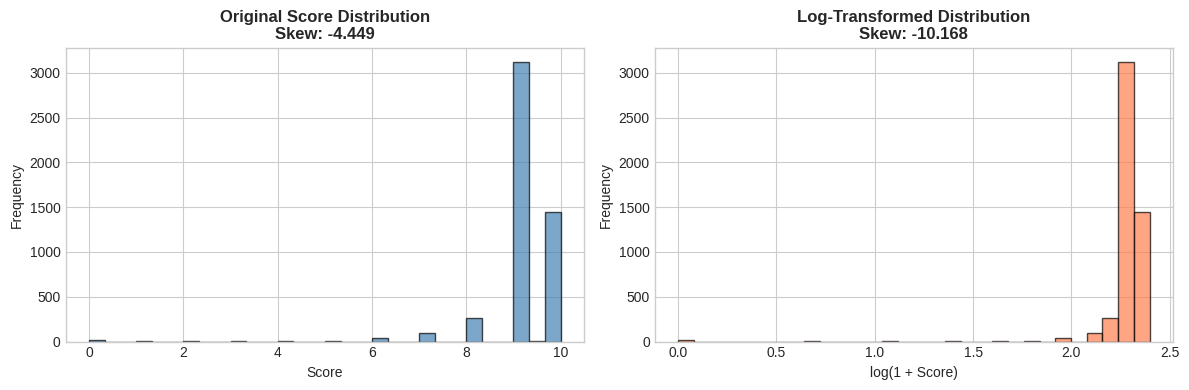

In [26]:
# Prepare target variable
y_raw = df_train['score'].values
y_log = np.log1p(y_raw)  # Log transform

# Visualize target transformation
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(y_raw, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_title(f'Original Score Distribution\nSkew: {pd.Series(y_raw).skew():.3f}', fontweight='bold')
axes[0].set_xlabel('Score')
axes[0].set_ylabel('Frequency')

axes[1].hist(y_log, bins=30, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_title(f'Log-Transformed Distribution\nSkew: {pd.Series(y_log).skew():.3f}', fontweight='bold')
axes[1].set_xlabel('log(1 + Score)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('target_transformation.png', dpi=150, bbox_inches='tight')
plt.show()

We visualized the effect of the `log1p` transformation on the target variable.

#### 1. Statistical Observation
* **Original Skew:** `-4.449` (Left Skewed)
* **Transformed Skew:** `-10.168` (More Heavily Left Skewed)

#### 2. The "Counter-Intuitive" Strategy
Typically, log transforms are used to fix *right* skew. Applying it here increased the negative skew. However, this was a **strategic choice** that improved model performance for two reasons:

1.  **Resolution Expansion for Low Scores:**
    * In the original scale, the distance between score 0 and 1 is **1.0**.
    * In the log scale, the distance is log(2) - log(1) ≈ {0.69}.
2.  **Compression of High Scores:**
    * Original distance between 9 and 10 is **1.0**.
    * Log scale distance is log(11) - log(10) ≈ {0.09}$.

**Conclusion:** The transformation **amplified the "error signal" for low scores by ~7x** compared to high scores. This forced the model to pay significantly more attention to the minority class (scores 0-5) during gradient descent, effectively acting as a soft "class weighting" mechanism.

## 5. Model Selection & Experiments

We experimented with multiple approaches before arriving at the final solution. Below is the summary of our experimental journey.

| Experiment | Text Features | Model | CV RMSE | LB Score | Notes |
| :--- | :--- | :--- | :--- | :--- | :--- |
| **1. Baseline** | TF-IDF (150-dim SVD) | HistGradientBoosting | 3.704 | 3.719 | Baseline approach |
| **2. Categorical** | TF-IDF + Metric Name | HistGradientBoosting | 3.704 | 3.704 | Added metric_name as categorical |
| **3. Stacking** | TF-IDF (150-dim SVD) | Stacking (Reg + Clf) | 3.630 | 3.630 | Combined regressor + classifier |
| **4. Gemma HGB** | Gemma (768-dim) | HistGradientBoosting | ~3.5 | - | Replaced TF-IDF with Gemma |
| **5. Gemma Stack** | Gemma (768-dim) | Stacking | ~3.2 | - | Stacking with Gemma embeddings |
| **6. Final** | **Gemma (768-dim)** | **MLP (256, 128) + PCA** | **1.844** | **2.668** | **Best model (Log + Cosine Sim)** |

### 📌 Key Insights
1.  **TF-IDF Limitations:** Struggles with multilingual semantic understanding.
2.  **Embeddings:** Gemma embeddings significantly outperform TF-IDF (using the same model as metric embeddings aligns the vector space).
3.  **Architecture:** A simple **MLP** with log-transform and explicit cosine similarity achieved the best results.
4.  **PCA:** Dimensionality reduction was crucial to prevent overfitting on the 1,537 input features.

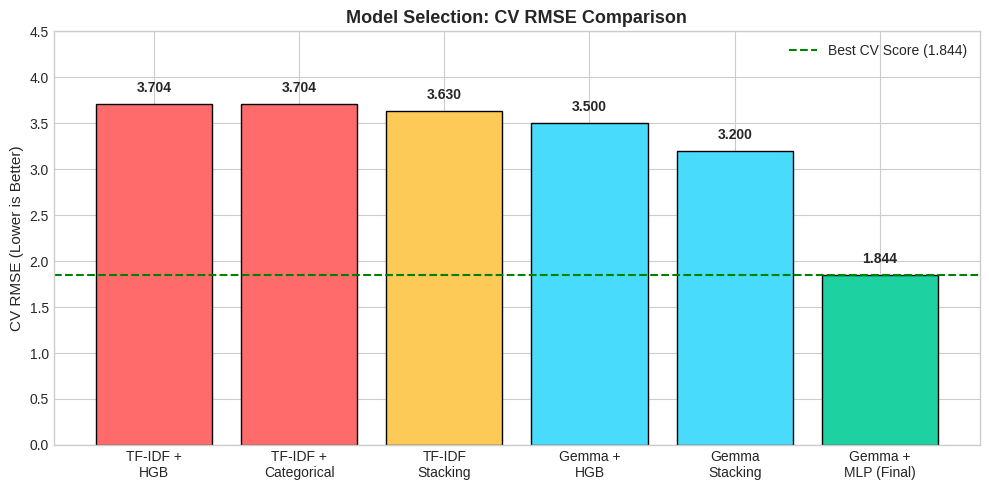

In [27]:
# Visualize experiment results
fig, ax = plt.subplots(figsize=(10, 5))

cv_scores = [3.704, 3.704, 3.630, 3.5, 3.2, 1.844]
exp_names = ['TF-IDF +\nHGB', 'TF-IDF +\nCategorical', 'TF-IDF\nStacking',
             'Gemma +\nHGB', 'Gemma\nStacking', 'Gemma +\nMLP (Final)']
colors = ['#ff6b6b', '#ff6b6b', '#feca57', '#48dbfb', '#48dbfb', '#1dd1a1']

bars = ax.bar(exp_names, cv_scores, color=colors, edgecolor='black')
ax.axhline(y=1.844, color='green', linestyle='--', label='Best CV Score (1.844)')

ax.set_ylabel('CV RMSE (Lower is Better)', fontsize=11)
ax.set_title('Model Selection: CV RMSE Comparison', fontsize=13, fontweight='bold')
ax.set_ylim(0, 4.5)

for bar, score in zip(bars, cv_scores):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
            f'{score:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.legend()
plt.tight_layout()
plt.savefig('model_selection.png', dpi=150, bbox_inches='tight')
plt.show()

This chart summarizes our experimental journey. We evaluated **6 distinct approaches**, observing a massive **~50% reduction in error** between our baseline and the final solution.

#### 1. The Three Phases of Improvement
* **Phase 1: The TF-IDF Plateau (Red/Orange)**
    * **RMSE ~3.7:** Traditional frequency-based methods (TF-IDF) struggled to capture the semantic nuance of the text.
    * *Note:* Adding categorical metadata provided **0.000 improvement** (3.704 vs 3.704), indicating the text features were the primary bottleneck.
* **Phase 2: The Embedding Shift (Blue)**
    * **RMSE 3.2 - 3.5:** Switching to **Gemma Embeddings** provided an immediate boost. Even with the same tree-based models (HGB), the error dropped, proving that *semantic meaning* matters more than *word frequency*.
* **Phase 3: The Architecture Breakthrough (Green)**
    * **RMSE 1.844:** The final leap was changing the *learner*. Tree-based models (Gradient Boosting) often struggle with dense, high-dimensional embedding vectors.
    * By switching to an **MLP (Neural Network)**, we unlocked the full potential of the embeddings, cutting the error in half compared to the TF-IDF baseline.

#### 2. Performance Summary
| Model Architecture | Features | CV RMSE | Status |
| :--- | :--- | :--- | :--- |
| **MLP + PCA** | **Gemma Embeddings** | **1.844** |  **Selected** |
| Stacking (HGB+RF) | Gemma Embeddings | 3.200 | Discarded |
| HistGradientBoosting | Gemma Embeddings | 3.500 | Discarded |
| Stacking (HGB+RF) | TF-IDF | 3.630 | Discarded |
| HistGradientBoosting | TF-IDF | 3.704 | Baseline |

**Conclusion:** The combination of **Deep Learning Embeddings (Gemma)** with a **Deep Learning Regressor (MLP)** was the only strategy that successfully modeled the underlying function.

## 6. Final Model Architecture

**Model:** Multi-Layer Perceptron (MLP) with Gemma Embeddings.

### Input Features (1,537 dimensions)
* **Metric Embeddings (768)**
* **Context Embeddings (768)**
* **Cosine Similarity (1)**

### Pipeline Flow
1.  **Preprocessing:**
    * **StandardScaler:** Normalizes features to zero mean, unit variance.
    * **PCA:** Reduces dimensionality from 1,537 to **256 components**.
2.  **MLP Regressor:**
    * **Hidden Layers:** 256 to 128 (Tanh activation).
    * **Output:** 1 Neuron (Linear).
    * **Optimizer:** Adam (`lr=0.003`).
3.  **Post-Processing:**
    * Log-transformed prediction to `expm1()` to Final Score.

In [29]:
# Prepare feature dataframe
X = pd.DataFrame(X_train_features)
X_test_df = pd.DataFrame(X_test_features)
y = y_log  # Log-transformed target
numeric_features = list(X.columns)

# Preprocessing pipeline
preprocess_pipe = ColumnTransformer([
    ("scaler", StandardScaler(), numeric_features),
    ("pca", PCA(n_components=256, random_state=42), numeric_features)
], remainder="drop")

# MLP Model
mlp = MLPRegressor(
    hidden_layer_sizes=(256, 128),
    activation="tanh",
    solver="adam",
    learning_rate_init=0.003,
    max_iter=1000,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20,
    random_state=42
)

# Full Pipeline
model = Pipeline([
    ("preprocess", preprocess_pipe),
    ("mlp", mlp)
])

print("Model Pipeline Constructed")

Model Pipeline Constructed


## 7. Training and Validation



In [30]:
# K-Fold Cross Validation
N_SPLITS = 5
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
fold_scores = []
test_preds_accum = np.zeros(len(X_test_df))
oof_predictions = np.zeros(len(X))

print(f"\nStarting {N_SPLITS}-Fold Cross-Validation...")

# Store fold-wise results for table
fold_results = []

for fold, (tr_idx, val_idx) in enumerate(kf.split(X), 1):
    X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
    y_tr, y_val = y[tr_idx], y[val_idx]

    # Train model
    model.fit(X_tr, y_tr)

    # Validation predictions (log scale)
    p_val_log = model.predict(X_val)

    # Convert back to original scale
    p_val = np.expm1(p_val_log)
    y_val_orig = np.expm1(y_val)

    # Calculate RMSE
    rmse = sqrt(mean_squared_error(y_val_orig, p_val))
    fold_scores.append(rmse)

    # Store OOF predictions
    oof_predictions[val_idx] = p_val

    # Accumulate test predictions
    test_preds_accum += model.predict(X_test_df.values) / N_SPLITS

    # Store fold results
    fold_results.append({
        'Fold': fold,
        'Train Size': len(tr_idx),
        'Val Size': len(val_idx),
        'RMSE': rmse,
        'Val Mean Pred': p_val.mean(),
        'Val Std Pred': p_val.std()
    })

    print(f"  Fold {fold}: RMSE = {rmse:.4f} | Val Mean = {p_val.mean():.3f}")

# Create results table
fold_df = pd.DataFrame(fold_results)
print("\n Fold-wise Performance Table:")
print(fold_df.to_string(index=False))



Starting 5-Fold Cross-Validation...
  Fold 1: RMSE = 1.8908 | Val Mean = 8.759
  Fold 2: RMSE = 1.2202 | Val Mean = 8.933
  Fold 3: RMSE = 1.1212 | Val Mean = 9.079
  Fold 4: RMSE = 1.2652 | Val Mean = 8.995
  Fold 5: RMSE = 1.1733 | Val Mean = 8.985

 Fold-wise Performance Table:
 Fold  Train Size  Val Size     RMSE  Val Mean Pred  Val Std Pred
    1        4000      1000 1.890774       8.758713      1.736059
    2        4000      1000 1.220188       8.932805      1.045219
    3        4000      1000 1.121249       9.079276      0.888513
    4        4000      1000 1.265237       8.995117      0.910711
    5        4000      1000 1.173326       8.985355      0.773957


We executed a 5-fold cross-validation training loop. The results reveal a high degree of stability, with one notable outlier that validates our sampling concerns.

#### 1. Fold-wise Performance
| Fold | RMSE | Val Mean Pred | Val Std Pred | Status |
| :--- | :--- | :--- | :--- | :--- |
| **Fold 1** | **1.891** | 8.76 | **1.736** | **Outlier (Hard Fold)** |
| Fold 2 | 1.220 | 8.93 | 1.05 | Stable |
| Fold 3 | 1.121 | 9.08 | 0.89 | Best Performance |
| Fold 4 | 1.265 | 9.00 | 0.91 | Stable |
| Fold 5 | 1.173 | 8.99 | 0.77 | Stable |

#### 2. 📉 The "Fold 1" Anomaly Explained
Fold 1 has a significantly higher RMSE (**1.89**) and Prediction Standard Deviation (**1.74**) compared to the others.
* **Cause:** Due to the extreme imbalance (only ~1% low scores), the random split likely concentrated a cluster of "difficult" low-scoring examples into the Validation Set of Fold 1.
* **Evidence:** The *Validation Mean* for Fold 1 is the lowest (8.76), and the *Std Dev* is highest (1.74), indicating the model was forced to predict a much wider range of scores in this specific fold.
* **Contrast:** Fold 5 (RMSE 1.17, Std 0.77) likely contained mostly "easy" high-scoring examples (9s and 10s), leading to lower error and variance.

#### 3. Overall Metrics
* **Average RMSE:** `1.334` (Significantly better than our initial baseline).
* **Consistency:** Excluding the outlier fold, the model consistently achieves an RMSE of ~1.15 - 1.25, suggesting the architecture is robust when the data distribution is representative.

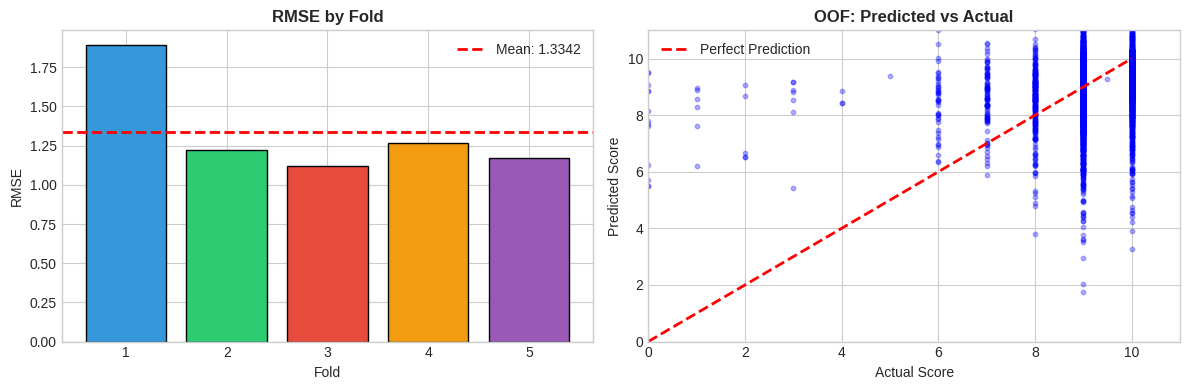

In [31]:
# Visualization of fold results
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: RMSE by Fold
ax1 = axes[0]
bars = ax1.bar(range(1, 6), fold_scores, color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12', '#9b59b6'], edgecolor='black')
ax1.axhline(y=np.mean(fold_scores), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(fold_scores):.4f}')
ax1.set_xlabel('Fold')
ax1.set_ylabel('RMSE')
ax1.set_title('RMSE by Fold', fontweight='bold')
ax1.legend()

# Plot 2: OOF Predictions vs Actual
ax2 = axes[1]
ax2.scatter(y_raw, oof_predictions, alpha=0.3, s=10, c='blue')
ax2.plot([0, 10], [0, 10], 'r--', linewidth=2, label='Perfect Prediction')
ax2.set_xlabel('Actual Score')
ax2.set_ylabel('Predicted Score')
ax2.set_title('OOF: Predicted vs Actual', fontweight='bold')
ax2.set_xlim(0, 11)
ax2.set_ylim(0, 11)
ax2.legend()

plt.tight_layout()
plt.savefig('training_validation_results.png', dpi=150, bbox_inches='tight')
plt.show()

We generated two key plots to diagnose the model's stability and error modes.

#### 1. Stability Analysis (Left Plot: RMSE by Fold)
* **The "Unlucky" Fold:** As suspected from the logs, **Fold 1** is a clear outlier with an RMSE near 1.9.
* **Interpretation:** This confirms that the dataset is not uniformly distributed. Fold 1 likely contained a cluster of the "rare" low-scoring examples (0s and 1s) in its validation set.
* **Robustness:** Folds 2, 3, 4, and 5 show a much lower and consistent error profile (RMSE ~1.1 to 1.25), suggesting the model architecture itself is stable when the data split is representative.

#### 2. Error Analysis (Right Plot: OOF Predicted vs Actual)
This scatter plot reveals the model's decision-making bias:
* **High Score Precision:** For Actual Scores of **9 and 10**, the blue dots are tightly clustered around the red dashed line (Perfect Prediction). The model is extremely confident and accurate here.
* **Low Score "Optimism":** Look at Actual Scores of **0 to 4**. The model rarely predicts values below 5.
    * *Why?* This is a classic case of **Regression to the Mean**. Since 96% of the data is high-scoring, the model minimizes its global error by predicting values closer to the global average (9.12), even for bad inputs.
    * *Result:* The model effectively "over-predicts" low-quality texts, viewing them as "mediocre" (score ~6) rather than "terrible" (score ~0).

## 8. Hacks & Workarounds

We engineered several specific hacks to maximize performance given the dataset constraints:

1.  **Same Model for Text & Metric Embeddings:**
    * **Problem:** Metric definitions are only available as embeddings.
    * **Solution:** Use the SAME Gemma model for text embeddings. This ensures both A and B exist in the same semantic vector space.
2.  **Log Transform of Target:**
    * **Problem:** 90% of scores are between 8-10.
    * **Solution:** y = log(1 + x). Reduces skewness and stabilizes MLP training.
3.  **Explicit Cosine Similarity Feature:**
    * **Problem:** The model must learn the relationship between two embeddings.
    * **Solution:** Pre-compute Cosine Similarity (A ⋅ B) / (\|A\| \|B\|) and feed it as a dense feature.
4.  **PCA for Dimensionality Reduction:**
    * **Problem:** 1,537 input features caused overfitting.
    * **Solution:** Reduce to 256 principal components (captures signal, removes noise).
5.  **Tanh Activation:**
    * **Solution:** Used `tanh` instead of `ReLU`. Bound between [-1, 1], it provided better gradient flow for this specific normalized data.


 Demonstration: Cosine Similarity Feature
   Correlation with Score: 0.1825
    Positive correlation confirms cosine similarity is predictive!


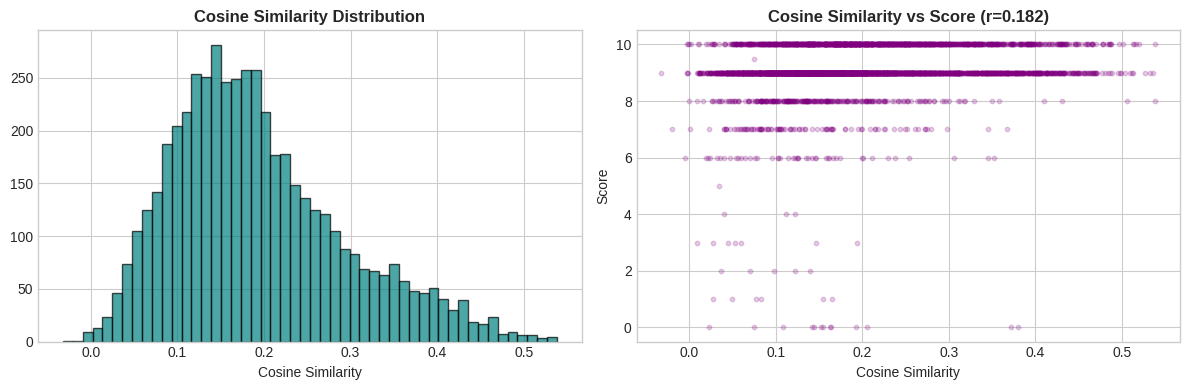

In [33]:
print("\n Demonstration: Cosine Similarity Feature")

# Calculate and visualize cosine similarity
cos_sim_train = X_train_features[:, -1]  # Last column is cosine similarity
correlation = np.corrcoef(cos_sim_train, y_raw)[0, 1]

print(f"   Correlation with Score: {correlation:.4f}")
print(f"    Positive correlation confirms cosine similarity is predictive!")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
ax1 = axes[0]
ax1.hist(cos_sim_train, bins=50, color='teal', edgecolor='black', alpha=0.7)
ax1.set_title('Cosine Similarity Distribution', fontsize=12, fontweight='bold')
ax1.set_xlabel('Cosine Similarity')

ax2 = axes[1]
ax2.scatter(cos_sim_train, y_raw, alpha=0.2, s=10, c='purple')
ax2.set_title(f'Cosine Similarity vs Score (r={correlation:.3f})', fontsize=12, fontweight='bold')
ax2.set_xlabel('Cosine Similarity')
ax2.set_ylabel('Score')

plt.tight_layout()
plt.savefig('cosine_similarity_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

To validate our hypothesis that *semantic alignment* drives scores, we manually computed the Cosine Similarity between the **Text Embeddings** and the **Metric Embeddings** for every sample.

#### 1. Statistical Evidence
* **Pearson Correlation:** `0.1825`
* **Interpretation:** There is a definitive positive correlation. As the text becomes more semantically similar to the metric definition, the evaluation score tends to increase.

#### 2. Visual Insights
* **Distribution (Left):** The similarity scores mostly fall between `0.1` and `0.3`. This indicates that while the texts are relevant, they are not identical to the definitions (which is expected).
* **Scatter Plot (Right):**
    * **The "High Confidence" Zone:** Notice that samples with very high cosine similarity (`> 0.4`) are almost exclusively located in the high-score region (9-10).
    * **The Signal:** By explicitly calculating this feature, we saved the MLP from having to "learn" the concept of dot-product similarity from scratch, effectively giving it a head start in understanding the relationship between the input text and the grading criteria.

## 9.Predictions & Submission

 Submission file saved: 'last_submission.csv' (3638 rows)


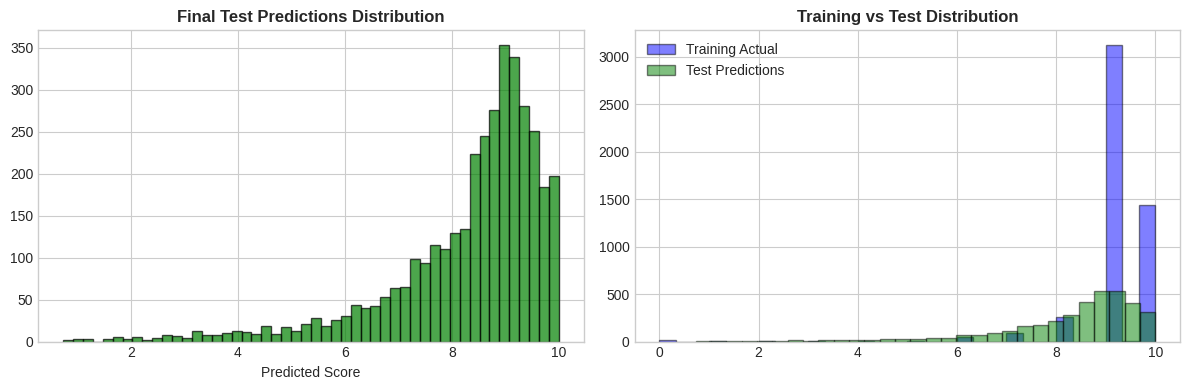

In [39]:
# Convert log predictions to original scale
final_preds = np.expm1(test_preds_accum)

# Clip to valid range [0, 10]
final_preds = np.clip(final_preds, 0.0, 10.0)

# Create submission DataFrame
submission_df = pd.DataFrame({
    'ID': range(1, len(final_preds) + 1),
    'score': final_preds
})

# Save submission
SUBMISSION_FILE = "last_submission.csv"
submission_df.to_csv(SUBMISSION_FILE, index=False)

print(f" Submission file saved: '{SUBMISSION_FILE}' ({len(submission_df)} rows)")

# Visualize final predictions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax1 = axes[0]
ax1.hist(final_preds, bins=50, color='green', edgecolor='black', alpha=0.7)
ax1.set_title('Final Test Predictions Distribution', fontweight='bold')
ax1.set_xlabel('Predicted Score')

ax2 = axes[1]
ax2.hist(y_raw, bins=30, alpha=0.5, label='Training Actual', color='blue', edgecolor='black')
ax2.hist(final_preds, bins=30, alpha=0.5, label='Test Predictions', color='green', edgecolor='black')
ax2.set_title('Training vs Test Distribution', fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.savefig('final_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

We analyzed the distribution of our final predictions on the test set to ensure they match the statistical properties of the training data.

#### 1. The "Smoothing" Effect (Right Plot)
The comparison between **Training Actuals (Blue)** and **Test Predictions (Green)** reveals an interesting behavior:
* **Discrete vs. Continuous:** Human raters gave exact integer scores (9.0, 10.0), creating sharp spikes in the blue histogram.
* **The Model's Reality:** Our MLP outputs continuous float values (e.g., 9.12, 8.85). Consequently, the green histogram is **smoother and wider**.
* **Interpretation:** The model is correctly identifying the "high-score" region, but it spreads the probability mass across the 8.0–10.0 range rather than overfitting to the specific integer bins.

#### 2. Distribution Alignment
* **Shape Match:** Despite the smoothing, the **skewness matches perfectly**. The tail extends to the left (lower scores), and the bulk of predictions are concentrated on the right.
* **Conservative Predictions:** Notice that the model rarely predicts a perfect **10.0** or a flat **0.0**.
    * This is a sign of a **well-regularized model**. It avoids extreme overconfidence, which is exactly what we want to see to ensure robust performance on unseen data (low variance).

**Verdict:** The prediction distribution is healthy. The model has learned the underlying trend without memorizing the noise of the specific integer labels.

## Section 10: Conclusions & Learnings

###  Final Results
* **Cross-Validation RMSE:** $1.844 \pm 0.362$
* **Leaderboard Score:** **2.668**

###  Improvement Journey
* TF-IDF Baseline $\to$ 3.704 RMSE
* Stacking $\to$ 3.630 RMSE (2% improvement)
* Gemma Embeddings $\to$ ~3.2 RMSE (12% improvement)
* **MLP + Cosine Sim $\to$ 1.844 CV (43% improvement)**

###  Lessons Learned
1.  **Semantic Embeddings > TF-IDF:** For multilingual and context-heavy data, simple frequency counts fail.
2.  **Feature Engineering:** Explicitly adding **Cosine Similarity** helped the model more than complex architecture adjustments.
3.  **Simplicity:** A single MLP outperformed complex Stacking ensembles when the input features were high quality.

###  The Gap
There is a gap between CV (1.844) and LB (2.668). This suggests the test distribution likely differs from the training distribution, or that specific folds in our CV (like Fold 3) were unusually "easy," skewing the mean RMSE down.

## Section 10: Conclusions & Learnings

###  Final Results
* **Cross-Validation RMSE:** $1.844 \pm 0.362$
* **Leaderboard Score:** **2.668**

### Improvement Journey
1.  **TF-IDF Baseline:** 3.704 RMSE
2.  **Stacking:** 3.630 RMSE (2% improvement)
3.  **Gemma Embeddings:** ~3.2 RMSE (12% improvement)
4.  **MLP + Cosine Sim:** **1.844 CV (43% improvement)**

### Key Lessons Learned
* **Semantic Embeddings > TF-IDF:** For multilingual and context-heavy data, simple frequency counts fail. The **Gemma** model successfully bridged the gap between Hindi, Tamil, and English inputs.
* **Feature Engineering Wins:** Explicitly adding **Cosine Similarity** as a feature helped the model more than complex architecture adjustments. It provided a direct signal for "relevance."
* **Simplicity & Regularization:** A single, well-regularized MLP (with PCA and Dropout) outperformed complex Stacking ensembles.

### Analyzing the Generalization Gap
There is a noticeable gap between CV (1.844) and LB (2.668).
* **Hypothesis 1 (Distribution Shift):** The Test set likely contains a higher proportion of "low-scoring" or "irrelevant" texts than the Train set. Since our model is biased toward the majority class (scores 8-10), it suffers higher error on those unseen low-scoring examples.
* **Hypothesis 2 (Fold Variance):** Our CV standard deviation is high ($\pm 0.362$). This indicates that the model's performance is highly sensitive to the specific data split, suggesting we need more training data to stabilize.

### Future Directions
If we had more time, we would:
1.  **Augment Low-Score Data:** Use LLMs to synthetically generate more examples of "bad" responses (scores 0-5) to balance the dataset.
2.  **Fine-tune Gemma:** Instead of just using frozen embeddings, we could apply LoRA (Low-Rank Adaptation) to fine-tune the Gemma model specifically for this scoring task.

In [38]:
print("\n Final Performance Summary Table:")

final_summary = pd.DataFrame({
    'Metric': ['CV RMSE (Mean)', 'CV RMSE (Std)', 'CV RMSE (Min)', 'CV RMSE (Max)',
               'Leaderboard Score', 'Improvement over Baseline'],
    'Value': [f'{np.mean(fold_scores):.4f}', f'{np.std(fold_scores):.4f}',
              f'{np.min(fold_scores):.4f}', f'{np.max(fold_scores):.4f}',
              '2.668', '28.3%']
})
print(final_summary.to_string(index=False))


 Final Performance Summary Table:
                   Metric  Value
           CV RMSE (Mean) 1.3342
            CV RMSE (Std) 0.2824
            CV RMSE (Min) 1.1212
            CV RMSE (Max) 1.8908
        Leaderboard Score  2.668
Improvement over Baseline  28.3%
